In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import json
import datetime
warnings.filterwarnings('ignore')

In [92]:
def get_clean_data(df_original):
    weekday_dict = {
        0:'Wd', 1:'Wd', 2:'Wd', 3:'Wd', 4:'Wd', 5:'F', 6:'F' 
    }
    
    df = df_original.copy(deep=True)
    df['date'] =  pd.to_datetime(df['datetime'].apply(lambda x: x[:10]), format='%Y-%m-%d')
    df['year'] = df['date'].dt.year
    df['time'] = pd.to_datetime(df['datetime'].apply(lambda x: x[:19])).dt.time
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['hour'] = df['datetime'].apply(lambda x: x[11:13]).astype(int)
    df['minute'] = df['datetime'].apply(lambda x: x[14:16]).astype(int)
    df['weekday'] = df['date'].dt.dayofweek
    df.replace({'weekday':weekday_dict}, inplace=True)
    df['season'] = np.where(df['month'].isin(list(range(4,10))), 'summer', 'winter')
    df['date_hour'] = df.apply(lambda x: datetime.datetime.combine(x['date'], x['time']), axis=1)
    df.set_index('date_hour', inplace=True)
    df = df[df.index < '2017']
    clean_df = df[['date', 'year', 'month', 'season', 'day','weekday','time', 'hour', 'minute', 'value']]
    clean_df = clean_df[~clean_df.index.duplicated()]
    clean_df['hour'] = np.where(clean_df['hour'].isin(np.arange(9,23)), 'Peak', 'off_peak')
    #clean_df['value'] = np.log1p(clean_df['value'])
    clean_df_freq = clean_df.asfreq('H')
    clean_df_freq['value'] = np.where(clean_df_freq['value'].isnull(), 0, clean_df_freq['value'])
    
    return clean_df_freq

### Price of secondary reserve up

In [93]:
raw_reserve_price = pd.read_csv('2014_2016_training_files/export_PrecioDeRegulaciónSecundariaSubir_2017-03-01_09-01.csv',
                               encoding='latin1', delimiter=';')
reserve_price = get_clean_data(raw_reserve_price).rename(columns={'value':'reserve'})

In [94]:
raw_spot_price = pd.read_csv('2014_2016_training_files/export_PrecioMercadoSPOTDiario_2017-02-02_09-47.csv', encoding='latin1', delimiter=';')
raw_spot_price = raw_spot_price[raw_spot_price['geoid'] == 3]
spot_price = get_clean_data(raw_spot_price)
spot_price = spot_price.rename(columns={'value':'spot'})

In [96]:
raw_demand = pd.read_csv('2014_2016_training_files/export_DemandaProgramada_2017-02-02_09-45.csv', encoding='latin1', delimiter=';')
demand = get_clean_data(raw_demand)
demand = demand.rename(columns={'value':'demand'})

In [97]:
spot_res_demand = reserve_price.merge(spot_price[['spot']], how='left', left_index=True, right_index=True)
spot_res_demand = spot_res_demand.merge(demand[['demand']], how='left', left_index=True, right_index=True)

In [98]:
spot_res_demand = spot_res_demand[['hour', 'weekday', 'season', 'spot','demand', 'reserve']]

In [99]:
for feature in ['hour', 'weekday', 'season']:
    spot_res_demand[pd.get_dummies(spot_res_demand[feature], drop_first=True).columns.tolist()] = pd.get_dummies(spot_res_demand[feature], drop_first=True)

In [100]:
for feature in ['demand', 'spot']:
    spot_res_demand[feature + '-1'] = spot_res_demand[feature].shift(periods=+1)
    spot_res_demand[feature + '-24'] = spot_res_demand[feature].shift(periods=+24)
spot_res_demand['reserve-24'] = spot_res_demand['reserve'].shift(periods=24)
spot_res_demand.dropna(subset=['demand-1', 'spot-1', 'demand-24', 'spot-24', 'reserve-24'], inplace=True)

### Preprocessing for Decision Tree

In [101]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold, train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.tree import export_graphviz
import graphviz

In [102]:
#Set features and output
X = spot_res_demand.drop(labels=['hour', 'weekday','season', 'reserve'], axis=1).values
Y = spot_res_demand['reserve'].values

In [103]:
spot_res_demand.drop(labels=['hour', 'weekday','season', 'reserve'], axis=1).corr()

,spot,demand,off_peak,Wd,winter,demand-1,demand-24,spot-1,spot-24,reserve-24
spot,1.000000,0.439919,-2.783381e-01,2.363609e-01,-3.468647e-02,0.404817,0.329957,0.966589,0.775106,0.376726
demand,0.439919,1.000000,-6.625166e-01,3.912105e-01,8.132363e-02,0.948428,0.809920,0.418370,0.330229,0.061910
off_peak,-0.278338,-0.662517,1.000000e+00,8.301321e-17,3.785815e-17,-0.629509,-0.661961,-0.259923,-0.277469,-0.003853
Wd,0.236361,0.391211,8.301321e-17,1.000000e+00,-3.754593e-03,0.386669,0.060234,0.235121,0.021726,0.012099
winter,-0.034686,0.081324,3.785815e-17,-3.754593e-03,1.000000e+00,0.081247,0.080349,-0.034518,-0.030061,0.041728
demand-1,0.404817,0.948428,-6.295088e-01,3.866694e-01,8.124694e-02,1.000000,0.771036,0.439960,0.303604,0.062932
demand-24,0.329957,0.809920,-6.619614e-01,6.023403e-02,8.034920e-02,0.771036,1.000000,0.313482,0.441500,0.087748
spot-1,0.966589,0.418370,-2.599225e-01,2.351214e-01,-3.451752e-02,0.439960,0.313482,1.000000,0.761681,0.375789
spot-24,0.775106,0.330229,-2.774686e-01,2.172575e-02,-3.006106e-02,0.303604,0.441500,0.761681,1.000000,0.437417
reserve-24,0.376726,0.061910,-3.852887e-03,1.209888e-02,4.172767e-02,0.062932,0.087748,0.375789,0.437417,1.000000


In [104]:
features_list = spot_res_demand.drop(labels=['hour', 'weekday','season', 'reserve'], axis=1).columns.tolist()

In [105]:
#Split data set into train and test
x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=0.8, 
                                                    test_size=0.2, random_state=0)

### Randomized Search CV

In [106]:
params = {
    'criterion':['mse'],
    'splitter':['best','random'],
    'max_features':['auto','log2', 'sqrt'],
    'max_depth':np.arange(2,10), 'min_samples_split':np.linspace(50, 1000, 200).astype(int),
    'min_samples_leaf': np.linspace(200, 2500, 50).astype(int), 'max_leaf_nodes': np.linspace(10,180, 40).astype(int)
}

In [107]:
#Random search, set up tree and cross-validation
tree = DecisionTreeRegressor()
kf = KFold(n_splits=5)

#Randomized Search CV for tree
random_search = RandomizedSearchCV(tree, param_distributions=params, n_jobs=-1, n_iter=350,
                                scoring='neg_mean_squared_error', cv=list(kf.split(x_train,y_train)), random_state=0)

In [108]:
%%time
random_search.fit(x_train, y_train);

Wall time: 1min


RandomizedSearchCV(cv=[(array([ 4205,  4206, ..., 21022, 21023]), array([   0,    1, ..., 4203, 4204])), (array([    0,     1, ..., 21022, 21023]), array([4205, 4206, ..., 8408, 8409])), (array([    0,     1, ..., 21022, 21023]), array([ 8410,  8411, ..., 12613, 12614])), (array([    0,     1, ..., 21022, 21023]), array([12615, 12616, ..., 16818, 16819])), (array([    0,     1, ..., 16818, 16819]), array([16820, 16821, ..., 21022, 21023]))],
          error_score='raise',
          estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best'),
          fit_params={}, iid=True, n_iter=350, n_jobs=-1,
          param_distributions={'splitter': ['best', 'random'], 'max_depth': array([2, 3, 4, 5, 6, 7, 8, 9]), 'criterion': ['mse'], 'min_samples_leaf': array(

In [109]:
best_params = random_search.cv_results_['params'][np.flatnonzero(random_search.cv_results_['rank_test_score']==1)[0]]
print(best_params)

{'splitter': 'best', 'min_samples_leaf': 293, 'criterion': 'mse', 'max_depth': 6, 'max_leaf_nodes': 140, 'max_features': 'auto', 'min_samples_split': 408}


In [110]:
tree.set_params(**best_params, random_state=0)

DecisionTreeRegressor(criterion='mse', max_depth=6, max_features='auto',
           max_leaf_nodes=140, min_impurity_split=1e-07,
           min_samples_leaf=293, min_samples_split=408,
           min_weight_fraction_leaf=0.0, presort=False, random_state=0,
           splitter='best')

In [111]:
#CV with kfold=5
kf = KFold(n_splits=5, random_state=0)

CV_mse = list()
CV_mae = list()

for train_index, test_index in kf.split(x_train, y_train):
    tree.fit(x_train[train_index], y_train[train_index])
    y_pred = tree.predict(x_train[test_index])
    CV_mae.append(mean_absolute_error(y_train[test_index], y_pred))
    CV_mse.append(mean_squared_error(y_train[test_index], y_pred))
    
print('Mean absolute error: %0.4f +- %0.4f' %(np.mean(CV_mae), 2*np.std(CV_mae)))
print('Mean squared error: %0.4f +- %0.4f' %(np.mean(CV_mse), 2*np.std(CV_mse)))

Mean absolute error: 12.5197 +- 0.0934
Mean squared error: 335.9028 +- 55.8166


In [112]:
CV_mae, CV_mse

([12.492530738433114,
  12.488791175396793,
  12.567524359807287,
  12.466066376523038,
  12.583381593623963],
 [326.47676641078465,
  316.83942214555395,
  320.71329521685794,
  391.33886618042123,
  324.14581811622134])

In [113]:
tree.fit(x_train, y_train)
print('MAE: ' +str(mean_absolute_error(y_train, tree.predict(x_train)))+', MSE: ' +
      str(mean_squared_error(y_train, tree.predict(x_train))))

MAE: 12.3335716722, MSE: 325.845179269


In [114]:
#Print test error and feature importance
print('MAE: ' +str(mean_absolute_error(y_test, tree.predict(x_test)))+', MSE: ' +
      str(mean_squared_error(y_test, tree.predict(x_test))))
pd.DataFrame(data=tree.feature_importances_, index=features_list)

MAE: 12.1880590722, MSE: 312.358751438


,0
spot,0.716998
demand,0.025491
off_peak,0.000000
Wd,0.000000
winter,0.003759
demand-1,0.003069
demand-24,0.037076
spot-1,0.030969
spot-24,0.004727
reserve-24,0.177911


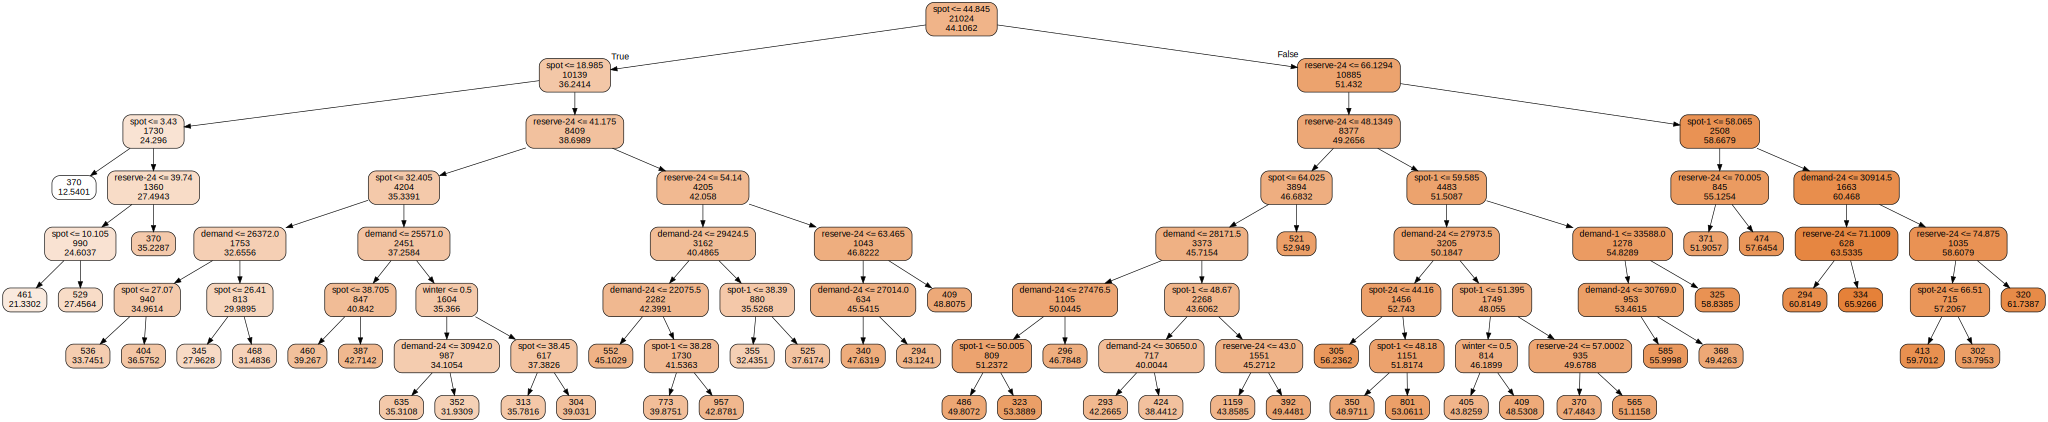

In [115]:
#Plot tree with graphviz
export_graphviz(tree, out_file="mytree.dot", max_depth=None, feature_names=features_list, label='none',
               filled=True, leaves_parallel=False, impurity=False, node_ids=False, proportion=False, rotate=False,
               rounded=True, special_characters=False)
with open("mytree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

In [116]:
Y.mean()

44.180020087064989

In [117]:
Y.std()

20.759582051612142

In [119]:
mean_absolute_error(y_test, tree.predict(x_test)) / Y.mean()

0.27587264669025868